<a href="https://colab.research.google.com/github/Gummadirajulavamshi/NLP/blob/main/nlp_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Dataset shape: (11370, 5)
Columns: ['id', 'keyword', 'location', 'text', 'target']

Class counts:
target
0    9256
1    2114
Name: count, dtype: int64

Random 3 disaster tweets:
['#StormBrendan Update-8.00 Tuesday.: Significant overtopping around high tide on Monday evening led to closure of Prom. Wa…', "British politicians are quick to call Israel an 'ally'. Yet when Britain was at war with Argentina, Israel was busy selli…", '1033) British Model Madalyn Davis dies in Sydney cliff fall. https://t.co/EZaWxVWY4y']

Random 3 irrelevant tweets:
['s 1656ABAF :Battle ID I need backup! Lvl 100 Colossus Omega https://t.co/YeOnr59F9Z', 'The place where these children once called home is no more after being bombed by #Assad and #Putin. We are so lucky they are…', 'i ordered one from @/wonu_hurricane ! good luck sis ~ https://t.co/Bm5CmpFREq']


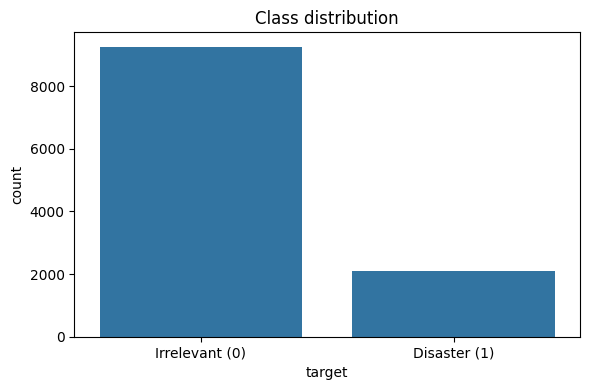

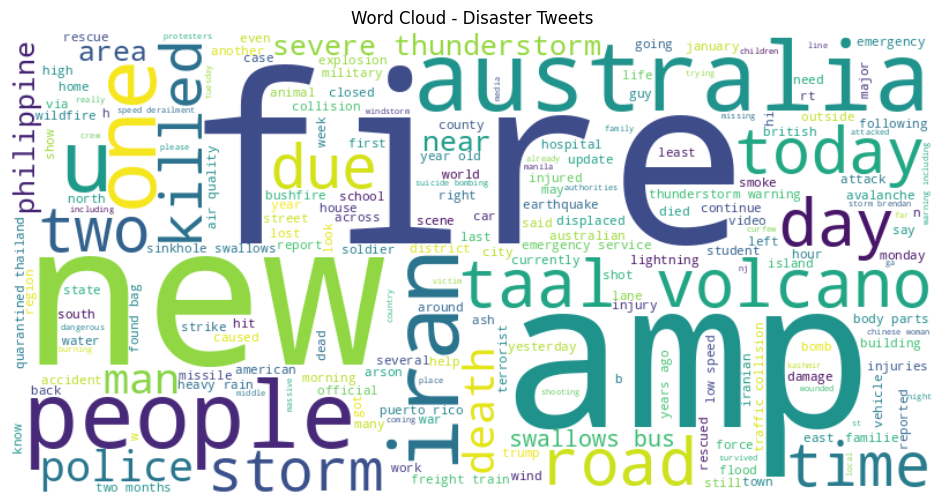

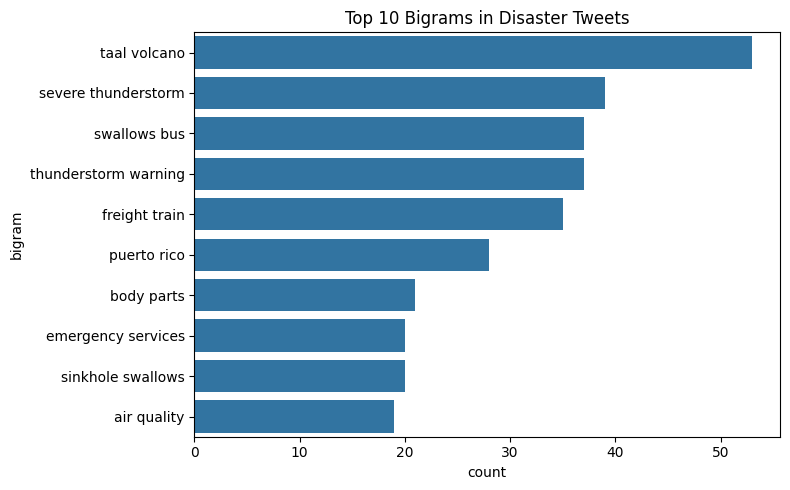

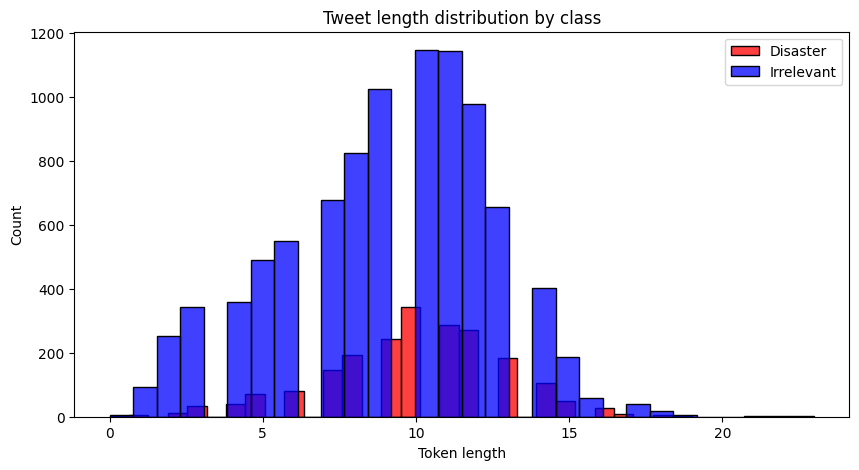


Mean token lengths:
target
0    9.106417
1    9.980605
Name: token_len, dtype: float64

Model: LogisticRegression
              precision    recall  f1-score   support

           0     0.8624    0.9887    0.9212      1851
           1     0.8618    0.3097    0.4557       423

    accuracy                         0.8624      2274
   macro avg     0.8621    0.6492    0.6884      2274
weighted avg     0.8623    0.8624    0.8346      2274


Model: RandomForest
              precision    recall  f1-score   support

           0     0.8870    0.9708    0.9270      1851
           1     0.7823    0.4586    0.5782       423

    accuracy                         0.8755      2274
   macro avg     0.8346    0.7147    0.7526      2274
weighted avg     0.8675    0.8755    0.8621      2274


Best model by F1: RandomForest


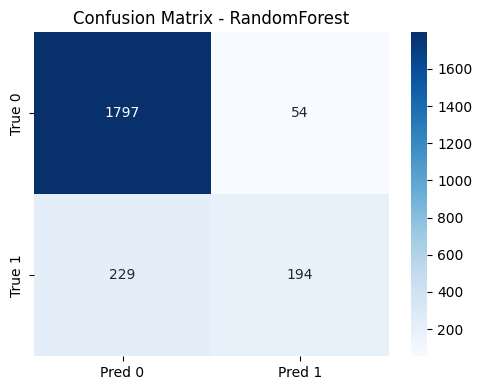

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
# Removed nltk.tokenize import
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Removed nltk.download("punkt") and nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")


df = pd.read_csv("/content/archive (3).zip")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nClass counts:")
print(df["target"].value_counts())

df = df.dropna(subset=["text"])
print("\nRandom 3 disaster tweets:")
print(df[df["target"]==1]["text"].sample(3, random_state=42).tolist())
print("\nRandom 3 irrelevant tweets:")
print(df[df["target"]==0]["text"].sample(3, random_state=42).tolist())

plt.figure(figsize=(6,4))
sns.countplot(x="target", data=df)
plt.xticks([0,1], ["Irrelevant (0)","Disaster (1)"])
plt.title("Class distribution")
plt.tight_layout()
plt.show()

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
wnl = WordNetLemmatizer()

def remove_urls_mentions_hashtags(text):
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    return text

emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
    "]+", flags=re.UNICODE)

def remove_emojis(text):
    return emoji_pattern.sub(r" ", text)

def normalize_elongated(word):
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def penn_to_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess(text):
    text = remove_urls_mentions_hashtags(text)
    text = remove_emojis(text)
    text = text.lower()
    # Use regex for tokenization
    tokens = re.findall(r'\b\w+\b', text) # Using regex to find words
    tokens = [normalize_elongated(t) for t in tokens]
    tokens = [t for t in tokens if t not in stop_words and t.isalpha()]
    return tokens

df["clean_tokens"] = df["text"].apply(preprocess)
df["clean_text"] = df["clean_tokens"].apply(lambda toks: " ".join(toks))

sample5 = df["text"].head(5).tolist()
stemmed = []
# lemmatized = [] # Commented out lemmatized list
for sent in sample5:
    toks = preprocess(sent)
    stemmed.append(" ".join([ps.stem(t) for t in toks]))
    # pos_tag still relies on NLTK resources, might fail again
    # If it fails, we might need to remove pos_tag and lemmatization or find an alternative
    # pos_tags = pos_tag(toks) # Commented out pos_tag call
    # lem = [] # Commented out lem list
    # for w, tag in pos_tags: # Commented out loop
    #     pos = penn_to_wordnet_pos(tag) # Commented out pos conversion
    #     lem.append(wnl.lemmatize(w, pos=pos)) # Commented out lemmatization
    # lemmatized.append(" ".join(lem)) # Commented out appending to lemmatized

# compare_df = pd.DataFrame({"Original": sample5, "Stemmed": stemmed, "Lemmatized": lemmatized}) # Commented out DataFrame creation
# print("\nOriginal -> Stemmed -> Lemmatized (first 5 tweets):") # Commented out print statement
# print(compare_df.to_string(index=False)) # Commented out print statement

disaster_texts = df[df["target"]==1]["clean_text"]
all_disaster_joined = " ".join(disaster_texts.tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=200).generate(all_disaster_joined)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Disaster Tweets")
plt.show()

bigram_vectorizer = CountVectorizer(ngram_range=(2,2), max_features=200, stop_words="english")
bigram_counts = bigram_vectorizer.fit_transform(disaster_texts)
bigram_sums = np.asarray(bigram_counts.sum(axis=0)).ravel()
bigrams = bigram_vectorizer.get_feature_names_out()
bigram_freq = sorted(list(zip(bigrams, bigram_sums)), key=lambda x: x[1], reverse=True)[:10]
bigram_df = pd.DataFrame(bigram_freq, columns=["bigram","count"])
plt.figure(figsize=(8,5))
sns.barplot(x="count", y="bigram", data=bigram_df)
plt.title("Top 10 Bigrams in Disaster Tweets")
plt.tight_layout()
plt.show()

df["token_len"] = df["clean_tokens"].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(df[df["target"]==1]["token_len"], label="Disaster", color="r", kde=False, bins=30)
sns.histplot(df[df["target"]==0]["token_len"], label="Irrelevant", color="b", kde=False, bins=30)
plt.legend()
plt.xlabel("Token length")
plt.title("Tweet length distribution by class")
plt.show()

print("\nMean token lengths:")
print(df.groupby("target")["token_len"].mean())

tfidf = TfidfVectorizer(max_features=7000, ngram_range=(1,2))
X = tfidf.fit_transform(df["clean_text"])
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lr = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

models = {"LogisticRegression": lr, "RandomForest": rf}
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred, digits=4))

best_model_name = max(results.items(), key=lambda x: x[1]["f1"])[0]
best_model = models[best_model_name]
print("\nBest model by F1:", best_model_name)

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()